# Testing

Testing the visualisation and gradcam code for correctness on a toy dataset of random shapes.

In [161]:
from skimage.draw import random_shapes
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageDraw

In [485]:
# coord_limits = [x_min,x_max, y_min, y_max]
def random_shapes(size, shape, min_size, max_size, coord_limits, background, color=True):
    # make sure that the shape will be visible within the given coord limits
    if background=="uniform":
        arr = np.ones((size, size, 3 if color else 1), dtype="uint8")
    else:
        arr = (np.random.rand(size, size, 3 if color else 1)*255).astype("uint8")
    
    im = Image.fromarray(arr)
    draw = ImageDraw.Draw(im)
    
    def draw_circle():
        x,y = np.random.randint(*coord_limits[:2]), np.random.randint(*coord_limits[2:])
        length = np.random.randint(min_size, max_size)
        coords = [x,y,x+length,y+length]
        fill = tuple(np.random.randint(0,256,3))
        draw.ellipse(coords, fill=fill)
    
    def draw_rect():
        x,y = np.random.randint(*coord_limits[:2]), np.random.randint(*coord_limits[2:])
        l1 = np.random.randint(min_size, max_size)
        l2 = np.random.randint(min_size, max_size)
        coords = [x,y,x+l1,y+l2]
        fill = tuple(np.random.randint(0,256,3))
        draw.rectangle(coords, fill=fill)
        
    def draw_tri():
        coords = [(np.random.randint(*coord_limits[:2]), np.random.randint(*coord_limits[2:])) for _ in range(3)]
        fill = tuple(np.random.randint(0,256,3))
        draw.polygon(coords,fill=fill)
        
    SHAPES = {'rectangle': (draw_rect, 0), 'circle': (draw_circle, 1), 'triangle': (draw_tri,2)}
    if shape is None: 
        fn, label = random.choice(list(SHAPES.values()))
    else:
        fn, label = SHAPES[shape]
    fn()
    return im, label

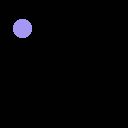

In [489]:
random_shapes(128, shape=None, min_size=0, max_size=100, coord_limits=[-10,128,-10,128], background='uniform')[0]

In [490]:
import torch
from torch import nn
import torchvision
from torch.utils.data import Dataset, DataLoader

In [491]:
def conv(ni, nf, ks=3, strd=1):
    return nn.Sequential(nn.Conv2d(ni, nf, ks, padding=ks//2, stride=strd), 
                         nn.ReLU(True))

In [514]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv(3, 12, strd=2)
        self.conv2 = conv(12, 24, strd=2)
        self.conv3 = conv(24, 36)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Linear(36, 3)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.head(self.pool(x).view(x.size(0),-1))
        return x

net = Network()

In [515]:
from torchvision import transforms

In [522]:
class RandomShape(Dataset):
    def __init__(self, size, ds_length, tfms=None):
        self.size = size
        self.l = ds_length
        
    def __len__(self):
        return self.l
    
    def __getitem__(self, _):
        s = random_shapes(self.size, shape=None, min_size=50, max_size=100, 
                             coord_limits=[-10,128,-10,128], background='uniform')
        return tfms(s[0]),s[1] if tfms is not None else s
    
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])
dataset = RandomShape(64, 1000, tfms=tfms)
dl = DataLoader(dataset, 32)

In [539]:
def accuracy(y_hat, y):
    return (y_hat.argmax(-1) == y).float().mean().item()

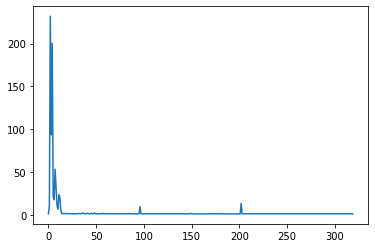

In [540]:
optim = torch.optim.Adam(net.parameters(), lr=0.1, weight_decay=1e-5)
crit = nn.CrossEntropyLoss()
EPOCHS = 10

device=torch.device('cpu')
losses = []
accs = []
for epoch in range(EPOCHS):
    for x,y in dl:
        x,y = x.to(device),y.to(device)
        
        preds = net(x)
        loss = crit(preds, y)
        accs.append(accuracy(preds, y))
        losses.append(loss.item())
        
        loss.backward()
        optim.step()
        optim.zero_grad()
        
plt.plot(losses)

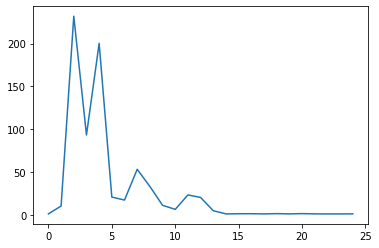

In [547]:
plt.plot(losses[:25])

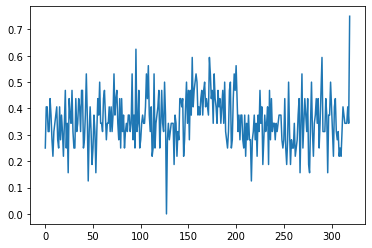

In [543]:
plt.plot(accs)

In [544]:
test_im, test_lb = next(iter(dl))

In [545]:
p = net(test_im)
p.argmax(-1)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])

In [546]:
p

tensor([[0.0502, 0.3055, 0.1928],
        [0.0502, 0.3055, 0.1928],
        [0.0502, 0.3055, 0.1928],
        [0.0502, 0.3055, 0.1928],
        [0.0502, 0.3055, 0.1928],
        [0.0502, 0.3055, 0.1928],
        [0.0502, 0.3055, 0.1928],
        [0.0502, 0.3055, 0.1928],
        [0.0502, 0.3055, 0.1928],
        [0.0502, 0.3055, 0.1928],
        [0.0502, 0.3055, 0.1928],
        [0.0502, 0.3055, 0.1928],
        [0.0502, 0.3055, 0.1928],
        [0.0502, 0.3055, 0.1928],
        [0.0502, 0.3055, 0.1928],
        [0.0502, 0.3055, 0.1928],
        [0.0502, 0.3055, 0.1928],
        [0.0502, 0.3055, 0.1928],
        [0.0502, 0.3055, 0.1928],
        [0.0502, 0.3055, 0.1928],
        [0.0502, 0.3055, 0.1928],
        [0.0502, 0.3055, 0.1928],
        [0.0502, 0.3055, 0.1928],
        [0.0502, 0.3055, 0.1928],
        [0.0502, 0.3055, 0.1928],
        [0.0502, 0.3055, 0.1928],
        [0.0502, 0.3055, 0.1928],
        [0.0502, 0.3055, 0.1928],
        [0.0502, 0.3055, 0.1928],
        [0.050